# Customer Churn Analysis

This notebook performs the research work on the [Credit Card Customers](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers/code) dataset from [Kaggle](https://www.kaggle.com/). Data analysis, processing and modeling are performed to obtain models able to predict customer churn.

This research notebook is transformed into a production-level code in the co-located files:

- `customer_churn/churn_library.py`
- `customer_churn/transformations.py`
- `test/test_churn_library.py`

Overview of contents:

- [1. Load Dataset](#1.-Load-Dataset)
- [2. Basic Exploratory Data Analysis (EDA)](#2.-Basic-Exploratory-Data-Analysis-(EDA))
- [3. Basic Feature Engineering](#3.-Basic-Feature-Engineering)
- [4. Model Definition, Training and Evaluation](#4.-Model-Definition,-Training-and-Evaluation)
- [5. Model Interpretation](#5.-Model-Interpretation)
- [6. Create Images of Evaluation Texts](#6.-Create-Images-of-Evaluation-Texts)
- [7. Further Tests for Production Code](#7.-Further-Tests-for-Production-Code)

## 1. Load Dataset

In [110]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report, roc_auc_score

from sklearn.utils import resample

In [111]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [112]:
filepath = "./data/bank_data.csv"
#filepath = "./data/BankChurners.csv"
df = pd.read_csv(filepath)
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [113]:
df.shape

(10127, 22)

In [114]:
data_sample = resample(df,
                       n_samples=100,
                       replace=False,
                       stratify=df['Attrition_Flag'],
                       random_state=0)

In [115]:
# Unnamed 0 seems to be a copy of the index; we can drop it
df.drop('Unnamed: 0',axis=1).head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 2. Basic Exploratory Data Analysis (EDA)

In [116]:
# Numerical columns
quant_columns = df.select_dtypes(['int64','float64']).columns

In [117]:
list(quant_columns)

['Unnamed: 0',
 'CLIENTNUM',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
Unnamed: 0                  10127 non-null int64
CLIENTNUM                   10127 non-null int64
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             10127 non-null object
Marital_Status              10127 non-null object
Income_Category             10127 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10127 non-null float

In [9]:
# How balanced is the dataset?
# We need to apply stratification in the train/test split
# If the models don't work well,
# we should start considering up/downsampling
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [10]:
# Are there any missing values?
# No missing values; we don't need to apply any imputations.
df.isnull().sum()

Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [11]:
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [12]:
# Automatically generated categorical/numerical columns
cols_cat = list(df.select_dtypes(['object']).columns)
print(cols_cat)
cols_num = list(df.select_dtypes(['int64','float64']).columns)
print(cols_num)

['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
['Unnamed: 0', 'CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [13]:
# Categorical columns: 5
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

# Quantitative columns: 14
quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

# 2 columns not considered: Unnamed, CLIENTNUM
# Target: 'Attrition_Flag'

In [14]:
# New Churn variable (target): 1 Yes, 0 No
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

Text(0.5,1,'Target = Churn: Yes 1, No 0')

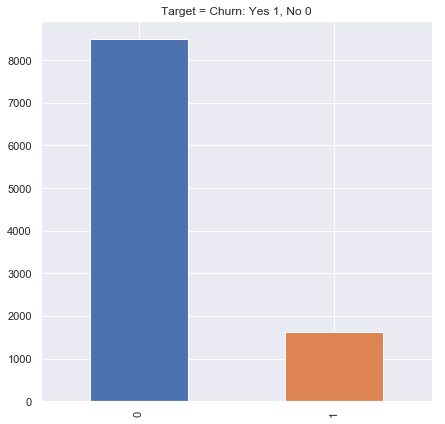

In [15]:
plt.figure(figsize=(7,7)) 
df['Churn'].value_counts().plot(kind='bar')
plt.title('Target = Churn: Yes 1, No 0')

Text(0.5,1,'Histogram of Customer_Age')

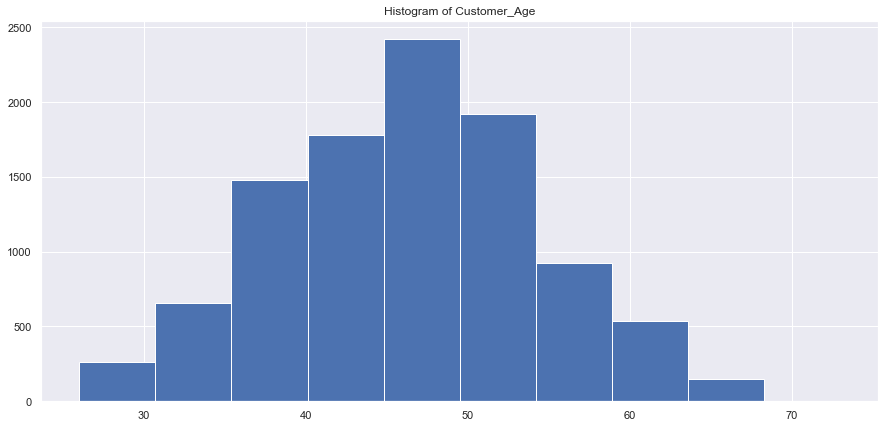

In [16]:
plt.figure(figsize=(15,7)) 
df['Customer_Age'].hist();
plt.title('Histogram of Customer_Age')

Text(0.5,1,'Counts of categories in Marital_Status')

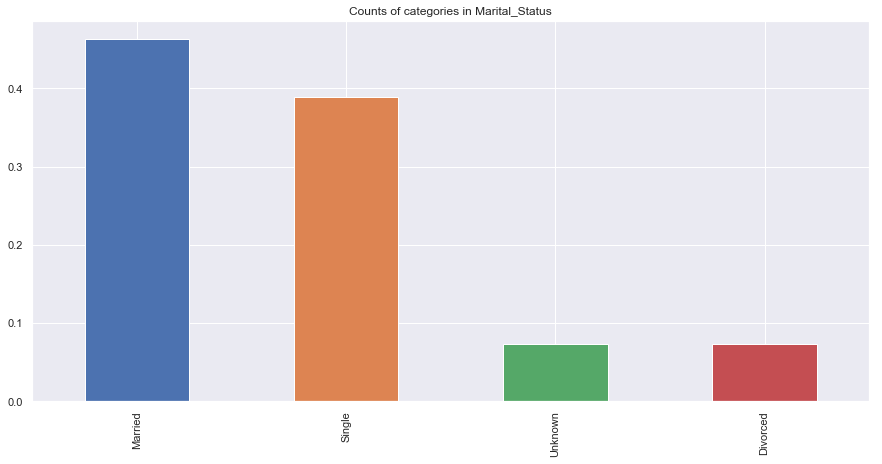

In [17]:
plt.figure(figsize=(15,7)) 
df.Marital_Status.value_counts('normalize').plot(kind='bar');
plt.title('Counts of categories in Marital_Status')

Text(0.5,1,'Distribution of Total_Trans_Ct')

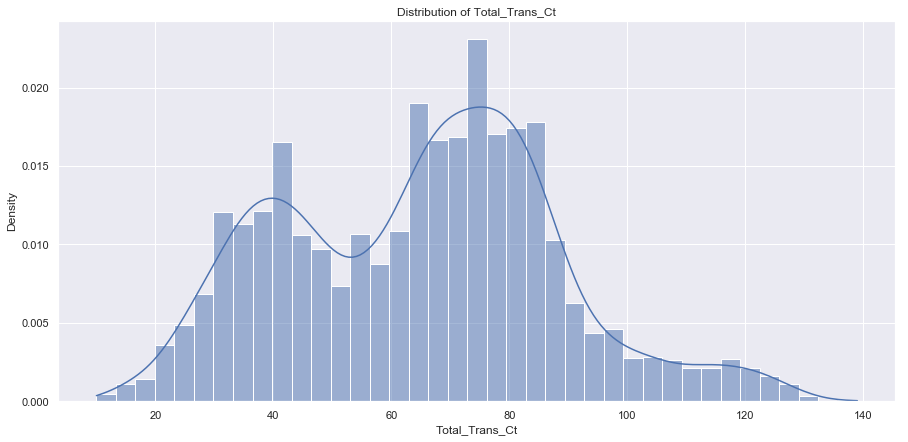

In [18]:
plt.figure(figsize=(15,7)) 
# distplot is deprecated. Use histplot instead
# sns.distplot(df['Total_Trans_Ct']);
# Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);
plt.title('Distribution of Total_Trans_Ct')

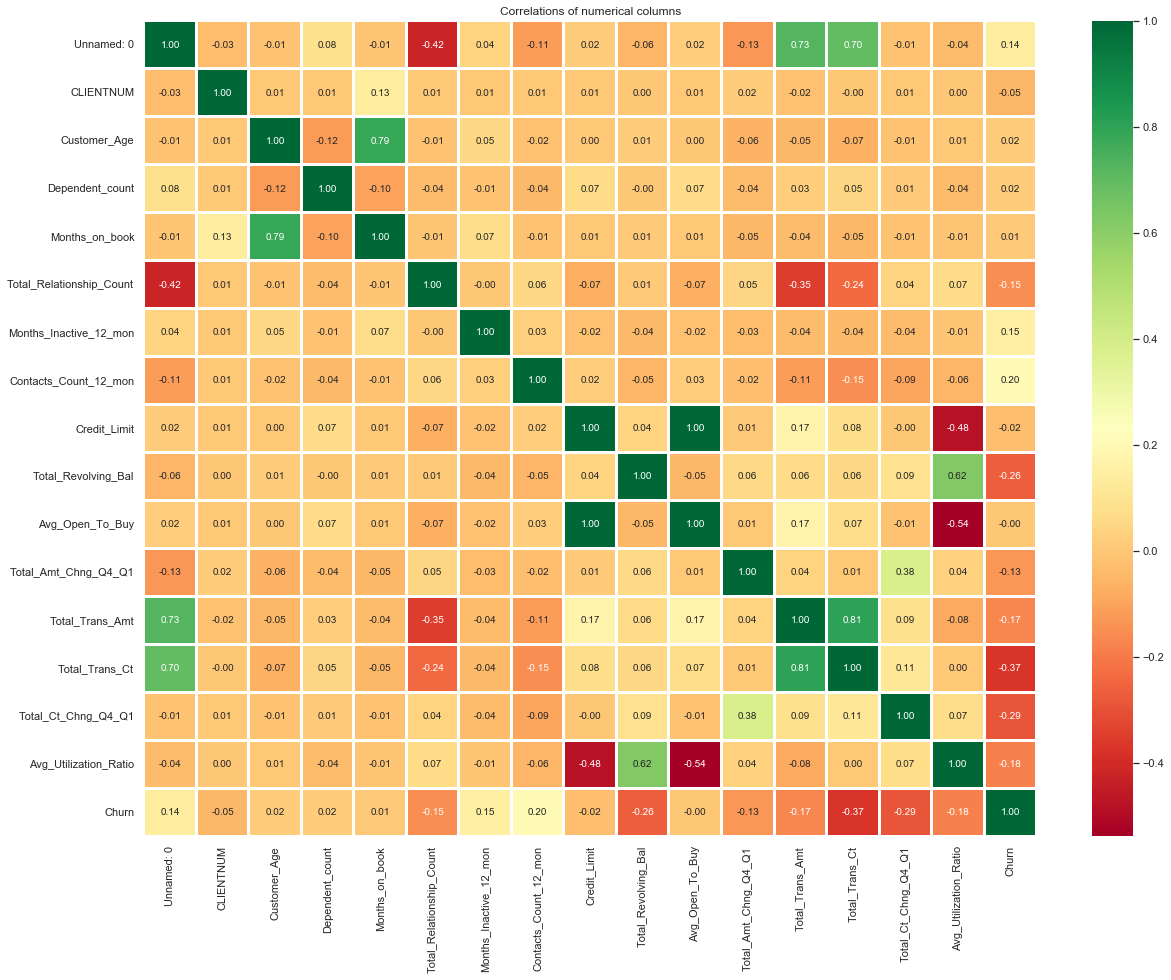

In [19]:
plt.figure(figsize=(20,15)) 
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', fmt=".2f", linewidths = 2) # cmap='Dark2_r'
plt.title('Correlations of numerical columns')
plt.show()

In [20]:
# Target: Binary classification
y = df['Churn']

## 3. Basic Feature Engineering

### Numerical Columns

In [21]:
from sklearn.preprocessing import PowerTransformer

In [22]:
# Usually, an absolute skew value larger than 0.75
# requires a transformation
for col in quant_columns:
    print(f'{col} skew: {df[col].skew()}')

Customer_Age skew: -0.033605016317173456
Dependent_count skew: -0.020825535616339912
Months_on_book skew: -0.10656535989402989
Total_Relationship_Count skew: -0.16245241498173682
Months_Inactive_12_mon skew: 0.6330611289713137
Contacts_Count_12_mon skew: 0.011005626218976492
Credit_Limit skew: 1.666725807993647
Total_Revolving_Bal skew: -0.14883725028007228
Avg_Open_To_Buy skew: 1.6616965459311595
Total_Amt_Chng_Q4_Q1 skew: 1.7320634114286024
Total_Trans_Amt skew: 2.0410034025756936
Total_Trans_Ct skew: 0.15367306849872275
Total_Ct_Chng_Q4_Q1 skew: 2.0640305679077477
Avg_Utilization_Ratio skew: 0.7180079967731994


In [23]:
# Example of Yeo-Johnson transformation of one variable
pt = PowerTransformer('yeo-johnson', standardize=False)
df['Credit_Limit_pt'] = pt.fit_transform(df['Credit_Limit'].values.reshape(-1,1))

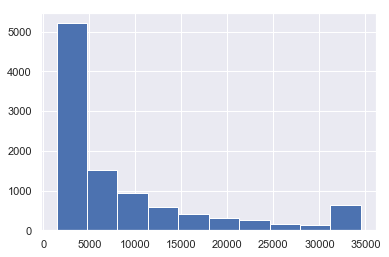

In [24]:
df['Credit_Limit'].hist()

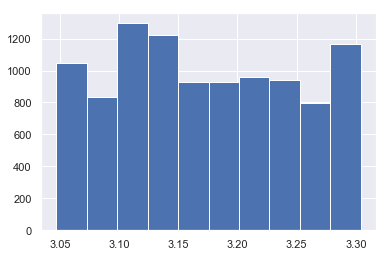

In [25]:
df['Credit_Limit_pt'].hist()

In [26]:
# Inverse transformation
df['Credit_Limit_pt_inv'] = pt.inverse_transform(df['Credit_Limit_pt'].values.reshape(-1,1))

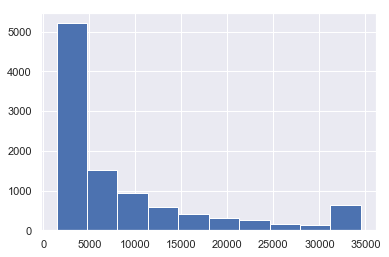

In [27]:
df['Credit_Limit_pt_inv'].hist()

In [28]:
# Automatic transformation of numerical columns
numerical_transformations = dict()
for col in quant_columns:
    if abs(df[col].skew()) > 0.75:
        pt = PowerTransformer('yeo-johnson', standardize=False)
        df[col] = pt.fit_transform(df[col].values.reshape(-1,1))
        numerical_transformations[col] = pt
        print(f'{col} new skew: {df[col].skew()}')

Credit_Limit new skew: 0.1029880801873443
Avg_Open_To_Buy new skew: -0.00889304780979028
Total_Amt_Chng_Q4_Q1 new skew: -0.08825056187176845
Total_Trans_Amt new skew: 0.0029372650487597663
Total_Ct_Chng_Q4_Q1 new skew: -0.06787486966594526


In [29]:
numerical_transformations.keys()

dict_keys(['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1'])

In [30]:
numerical_transformations['Credit_Limit'].lambdas_

array([-0.28766578])

### Categorical Columns

In [31]:
X = pd.DataFrame()

In [32]:
# Since we are going to create new features based on category ratios
# I print their value counts, just to have an overview
for col in cat_columns:
    print(f'\n{col}:\n{df[col].value_counts()}')


Gender:
F    5358
M    4769
Name: Gender, dtype: int64

Education_Level:
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

Marital_Status:
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

Income_Category:
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

Card_Category:
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


In [33]:
# 5 Categorical columns
# 'Gender'
# 'Education_Level'
# 'Marital_Status'
# 'Income_Category'
# 'Card_Category'        

# Gender encoded column
# Assign each data-point the churn ratio mean associated to its gender
gender_lst = []
gender_groups = df.groupby('Gender').mean()['Churn']

for val in df['Gender']:
    gender_lst.append(gender_groups.loc[val])

df['Gender_Churn'] = gender_lst    

# Education encoded column
# Assign each data-point the churn ratio mean associated to its education level
edu_lst = []
edu_groups = df.groupby('Education_Level').mean()['Churn']

for val in df['Education_Level']:
    edu_lst.append(edu_groups.loc[val])

df['Education_Level_Churn'] = edu_lst

# Marital encoded column
# Assign each data-point the churn ratio mean associated to its marital status
marital_lst = []
marital_groups = df.groupby('Marital_Status').mean()['Churn']

for val in df['Marital_Status']:
    marital_lst.append(marital_groups.loc[val])

df['Marital_Status_Churn'] = marital_lst

# Income encoded column
# Assign each data-point the churn ratio mean associated to its income category
income_lst = []
income_groups = df.groupby('Income_Category').mean()['Churn']

for val in df['Income_Category']:
    income_lst.append(income_groups.loc[val])

df['Income_Category_Churn'] = income_lst

# Card encoded column
# Assign each data-point the churn ratio mean associated to its card category
card_lst = []
card_groups = df.groupby('Card_Category').mean()['Churn']
 
for val in df['Card_Category']:
    card_lst.append(card_groups.loc[val])

df['Card_Category_Churn'] = card_lst

In [34]:
keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

X[keep_cols] = df[keep_cols]

In [35]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,3.246818,777,10.924763,0.596514,4.506686,42,0.742157,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,3.216614,864,10.287649,0.634983,4.552052,33,1.029180,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3.141653,0,9.278252,0.765820,4.689710,20,0.870893,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3.138637,2517,7.437941,0.610283,4.515499,20,0.870893,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,3.171240,0,9.696499,0.723576,4.375838,28,0.895156,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [36]:
# 14 numerical + 5 qualitative engineered to be also numerical ratios
X.shape

(10127, 19)

In [37]:
np.sum(X['Marital_Status_Churn'].isnull())

0

## 4. Model Definition, Training and Evaluation

In [38]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify=y, random_state=42)

In [40]:
# Model 1: Logistic Regression
# Note: if the default solver='lbfgs' fails to converge, use another
# https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lr_pipe = Pipeline([
    ("polynomial_features", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver='liblinear', random_state=42, max_iter=3000))])

# Grid Search: Logistic Regression (Model 1)
# Since we use polynomial features,
# we cannot easily plot feature importances in the current implementation
params_grid_lr = {
    'polynomial_features__degree': [1, 2],
    'model__penalty': ['l1', 'l2'],
    'model__C': np.geomspace(1e-3, 10, 4) # logarithmic jumps
}
lr_pipe_cv = GridSearchCV(estimator=lr_pipe, param_grid=params_grid_lr, cv=5, scoring='roc_auc')
t1 = time.time()
lr_pipe_cv.fit(X_train, y_train)
# Get best logistic regression model/pipeline
lr_pipe_cv_best = lr_pipe_cv.best_estimator_
t2 = time.time()
print(f"Logistic regression trained with grid search and cross validation in {t2-t1:.2f} sec.")

Logistic regression trained with grid search and cross validation in 420.64 sec.


In [41]:
# Best model parameters
str(lr_pipe_cv.best_params_)

"{'model__C': 10.0, 'model__penalty': 'l1', 'polynomial_features__degree': 2}"

In [42]:
# Best score on train split (ROC AUC)
lr_pipe_cv.best_score_

0.9668563301086328

In [79]:
# Model 2: Random Forest Classifier
# Note: scaling is really not necessary for random forests...
# Polynomial features removed to plot feature importances
rf_pipe = Pipeline([
    #("polynomial_features", PolynomialFeatures()),
    #("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42))])

# Grid Search: Random Forest (Model 2)
params_grid_rf = {
    #'polynomial_features__degree': [1], # [1, 2]
    'model__n_estimators': [200, 500],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [4, 5, 100],
    'model__criterion': ['gini', 'entropy']
}
rf_pipe_cv = GridSearchCV(estimator=rf_pipe, param_grid=params_grid_rf, cv=5, scoring='roc_auc')
t1 = time.time()
rf_pipe_cv.fit(X_train, y_train)
# Get best random forest model/pipeline
rf_pipe_cv_best = rf_pipe_cv.best_estimator_
t2 = time.time()
print(f"Random forest trained with grid search and cross validation in {t2-t1:.2f} sec.")

Random forest trained with grid search and cross validation in 198.84 sec.


In [80]:
# Best model parameters
str(rf_pipe_cv.best_params_)

"{'model__criterion': 'entropy', 'model__max_depth': 100, 'model__max_features': 'auto', 'model__n_estimators': 500}"

In [81]:
# Best score on train split (ROC AUC)
rf_pipe_cv.best_score_

0.9895518049096556

In [47]:
# Model 3: Support Vector Classifier
# Note: scaling is really not necessary for random forests...
# Polynomial features removed to plot feature importances
sv_pipe = Pipeline([
    ("polynomial_features", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("model", SVC(random_state=42))])

# Grid Search: Support Vector Machine (Model 3)
params_grid_sv = {
    'polynomial_features__degree': [1, 2],
    'model__kernel': ['poly', 'rbf'],
    'model__gamma': ['auto', 'scale'],
    'model__C': np.geomspace(1e-3, 10, 4)
}
sv_pipe_cv = GridSearchCV(estimator=sv_pipe, param_grid=params_grid_sv, cv=5, scoring='roc_auc')
t1 = time.time()
sv_pipe_cv.fit(X_train, y_train)
# Get best support vector machine model/pipeline
sv_pipe_cv_best = sv_pipe_cv.best_estimator_
t2 = time.time()
print(f"Support vector machine trained with grid search and cross validation in {t2-t1:.2f} sec.")

Support vector machine trained with grid search and cross validation in 194.33 sec.


In [48]:
# Best model parameters
str(sv_pipe_cv.best_params_)

"{'model__C': 10.0, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'polynomial_features__degree': 1}"

In [49]:
# Best score on train split (ROC AUC)
sv_pipe_cv.best_score_

0.9679994893972669

In [82]:
# Pack models
grids = (lr_pipe_cv, rf_pipe_cv, sv_pipe_cv)
models = (lr_pipe_cv_best, rf_pipe_cv_best, sv_pipe_cv_best)
model_names = ['logistic_regression_model_pipe.pkl',
               'random_forest_model_pipe.pkl',
               'support_vector_model_pipe.pkl']

# Training summary report + Save best models/pipelines
model_output_path = './models'
with open(model_output_path+'/training_report.txt', 'w') as f:
    f.write("Training report: \n")
    for i in range(len(models)):
        # Save report
        f.write(f"\nModel: {model_names[i]}:\n")
        f.write(f"- Best params: {str(grids[i].best_params_)}:\n")
        f.write(f"- Best ROC AUC (train split with CV): {str(grids[i].best_score_)}:\n")
        # Save model
        joblib.dump(models[i], model_output_path+'/'+model_names[i])

In [83]:
lr_pipe_cv_best = joblib.load(model_output_path+'/'+model_names[0])
rf_pipe_cv_best = joblib.load(model_output_path+'/'+model_names[1])
sv_pipe_cv_best = joblib.load(model_output_path+'/'+model_names[2])

In [84]:
# Predict test split

# Logistic Regression
y_train_preds_lr = lr_pipe_cv_best.predict(X_train)
y_test_preds_lr = lr_pipe_cv_best.predict(X_test)
# Random Forest
y_train_preds_rf = rf_pipe_cv_best.predict(X_train)
y_test_preds_rf = rf_pipe_cv_best.predict(X_test)
# Support Vector Machines
y_train_preds_sv = sv_pipe_cv_best.predict(X_train)
y_test_preds_sv = sv_pipe_cv_best.predict(X_test)

In [85]:
# Classification reports
print('--- logistic regression results ---')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))
print('--- random forest results ---')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))
print('--- support vector machines results ---')
print('test results')
print(classification_report(y_test, y_test_preds_sv))
print('train results')
print(classification_report(y_train, y_train_preds_sv))

--- logistic regression results ---
test results
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2551
           1       0.82      0.72      0.76       488

    accuracy                           0.93      3039
   macro avg       0.88      0.84      0.86      3039
weighted avg       0.93      0.93      0.93      3039

train results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5949
           1       0.86      0.79      0.83      1139

    accuracy                           0.95      7088
   macro avg       0.91      0.88      0.90      7088
weighted avg       0.95      0.95      0.95      7088

--- random forest results ---
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2551
           1       0.92      0.81      0.86       488

    accuracy                           0.96      3039
   macro avg       0.9

<Figure size 360x360 with 0 Axes>

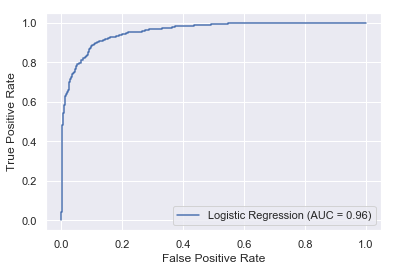

In [99]:
# ROC plots
plt.figure(figsize=(5,5))
lrc_plot = plot_roc_curve(lr_pipe_cv_best, X_test, y_test, name="Logistic Regression")

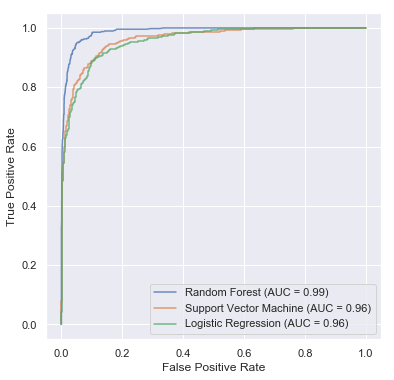

In [120]:
# Compile plots
plt.figure(figsize=(6, 6))
ax = plt.gca()
rfc_disp = plot_roc_curve(rf_pipe_cv_best, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")
svc_disp = plot_roc_curve(sv_pipe_cv_best, X_test, y_test, ax=ax, alpha=0.8, name="Support Vector Machine")
lrc_plot.plot(ax=ax, alpha=0.8, name="Logistic Regression")
plt.savefig('./images/results/roc_plots.png',dpi=300,transparent=False,bbox_inches='tight')

## 5. Model Interpretation

In [89]:
# Select (best) model
# WATCH OUT: SHAP seems to work only with models, not pipelines.
# Therefore, we need to take the model only;
# however, X_test needs to be modified according to the Pipeline
# before feeding it to SHAP.
# Luckily, the random forests model-pipeline has no transformation
model = rf_pipe_cv_best['model']

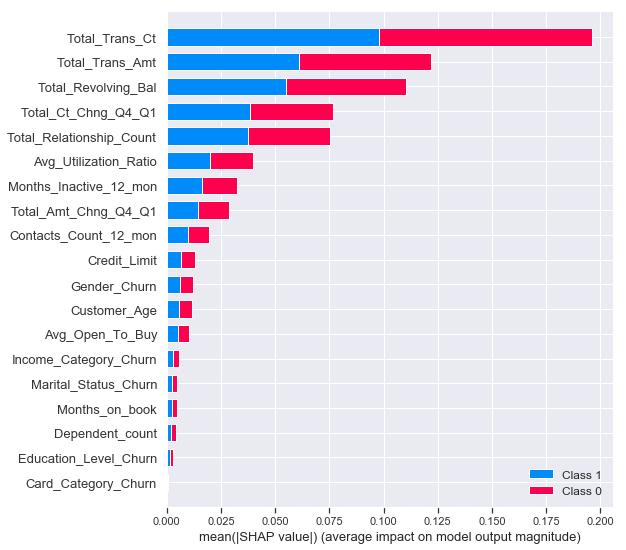

In [104]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

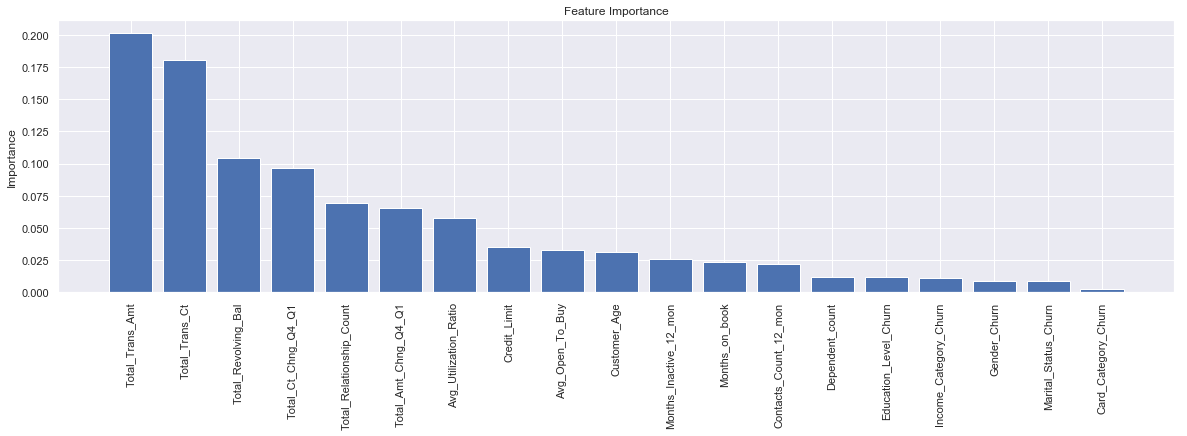

In [121]:
# Calculate feature importances
importances = model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

plt.savefig('./images/results/feature_importance_random_forest.png',dpi=300,transparent=False,bbox_inches='tight')

## 6. Create Images of Evaluation Texts

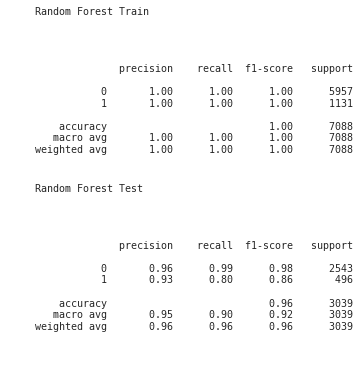

In [37]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


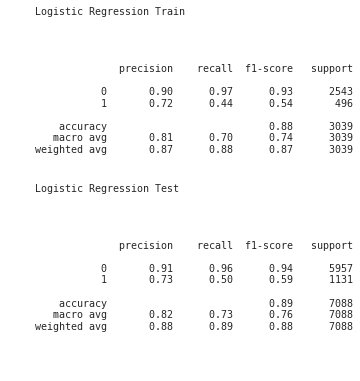

In [38]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');

## 7. Further Tests for Production Code

### Dataset sample

In [39]:
sample_filepath = filepath.split('.csv')[0]+'_sample.csv'
print(sample_filepath)

./data/bank_data_sample.csv


In [40]:
filepath = "./data/bank_data.csv"
data = pd.read_csv(filepath)

In [41]:
data_sample = data.iloc[:10,:]

### Transformations

In [42]:
from transformations import MeanImputer, ModeImputer, CategoryEncoder

In [43]:
meanImputer = MeanImputer(variables=['Customer_Age', 'Dependent_count'])

In [44]:
X_ = meanImputer.fit_transform(X)

In [45]:
meanImputer.imputer_dict_

{'Customer_Age': 46.32596030413745, 'Dependent_count': 2.3462032191172115}

In [46]:
X.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn',
       'Income_Category_Churn', 'Card_Category_Churn'],
      dtype='object')

In [47]:
data.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [48]:
data[['Gender','Education_Level']].mode().iloc[0].to_dict()

{'Gender': 'F', 'Education_Level': 'Graduate'}

In [49]:
modeImputer = ModeImputer(variables=['Gender','Education_Level'])

In [50]:
col_groups = data.groupby('Education_Level').mean()['Customer_Age']

In [51]:
col_groups.to_dict()

{'College': 45.970384995064165,
 'Doctorate': 47.26164079822616,
 'Graduate': 46.3235294117647,
 'High School': 46.34525583705911,
 'Post-Graduate': 45.56201550387597,
 'Uneducated': 46.42367182246133,
 'Unknown': 46.42857142857143}

In [52]:
my_dict = dict()

In [53]:
my_dict['Education_Level'] = col_groups.to_dict()

In [54]:
my_dict

{'Education_Level': {'College': 45.970384995064165,
  'Doctorate': 47.26164079822616,
  'Graduate': 46.3235294117647,
  'High School': 46.34525583705911,
  'Post-Graduate': 45.56201550387597,
  'Uneducated': 46.42367182246133,
  'Unknown': 46.42857142857143}}

In [55]:
df_ = modeImputer.fit_transform(df)

In [56]:
modeImputer.imputer_dict_

{'Gender': 'F', 'Education_Level': 'Graduate'}

In [57]:
categoryEncoder = CategoryEncoder(features=['Education_Level', 'Marital_Status'], target='Churn')

In [58]:
df_ = categoryEncoder.fit_transform(df)

In [59]:
categoryEncoder.imputer_dict_

{'Education_Level': {'College': 0.15202369200394866,
  'Doctorate': 0.2106430155210643,
  'Graduate': 0.15569053708439898,
  'High School': 0.15201192250372578,
  'Post-Graduate': 0.17829457364341086,
  'Uneducated': 0.1593813046402152,
  'Unknown': 0.1685319289005925},
 'Marital_Status': {'Divorced': 0.16176470588235295,
  'Married': 0.15126946874333264,
  'Single': 0.16941415166117169,
  'Unknown': 0.17222963951935916}}

In [60]:
np.sum(df_['Education_Level_Churn'] - X['Education_Level_Churn'])

0.0

In [61]:
list(categoryEncoder.imputer_dict_.keys())

['Education_Level', 'Marital_Status']

In [62]:
categoryEncoder.encoded_categoricals_

['Education_Level_Churn', 'Marital_Status_Churn']

In [5]:
from sklearn.utils import resample

In [8]:
resample(df, n_samples=5, replace=False, stratify=df['Attrition_Flag'],
...          random_state=0)

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
7998,7998,716315508,Attrited Customer,37,F,3,Post-Graduate,Married,$40K - $60K,Blue,...,2,5,3233.0,2517,716.0,0.000,1339,32,0.000,0.779
7833,7833,714986583,Existing Customer,55,F,4,Uneducated,Single,Less than $40K,Blue,...,2,2,4978.0,923,4055.0,0.883,5025,62,0.879,0.185
1094,1094,709584483,Existing Customer,33,F,3,Graduate,Married,Less than $40K,Blue,...,1,4,3030.0,2517,513.0,0.785,1805,44,0.467,0.831
9515,9515,719094333,Existing Customer,46,M,4,Uneducated,Married,$80K - $120K,Blue,...,2,1,13490.0,1567,11923.0,0.795,13159,105,0.750,0.116
6923,6923,713792583,Existing Customer,52,F,2,Graduate,Single,Unknown,Blue,...,2,3,10351.0,1356,8995.0,0.828,4572,76,1.054,0.131
